# Newton Examples

This notebook is to study the behavior of the function to root-find with Newton.
We use this to motivate our design for the optimal optimizer.

In [1]:
%load_ext autoreload
%autoreload 2

In [323]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import adelie as gl

## Upper Bound via Taylor Expansion

One possible way to construct the upper bound is to form a second-order Taylor expansion of $\varphi$ 
around $0$ and solve for the smaller root (guaranteed to be positive).

In [3]:
def h_max_taylor(L, v, l1, l2):
    L = L + l2
    l1_2 = l1 * l1
    l1_3 = l1_2 * l1
    l1_4 = l1_3 * l1
    v_square = v ** 2
    v_square_L = v_square * L
    c = np.sum(v_square) / l1_2
    b = -2 * np.sum(v_square_L) / l1_3
    a = 3 * np.sum(v_square_L * L) / l1_4
    discr = np.maximum(b * b - 4 * a * c, 0) 
    return np.maximum(-b - np.sqrt(discr) / (2 * a), 0)

In [ ]:
np.random.seed(0)
x = np.linspace(0, 10, 100)
p = 1000
L = np.concatenate(
    [np.zeros(int(p*0.2)), np.random.uniform(1e-14, 1e-8, int(p*0.1)), np.random.uniform(0.8, 2, p)],
)
v = np.random.normal(0, 1, len(L)) * np.sqrt(L)
l1 = 1e-4
l2 = 0

(
    gl.bcd_root_upper_bound(L+l2, v, l1, 1e-10)['h_max'],
    h_max_taylor(L, v, l1, l2), 
    np.linalg.norm(gl.newton_abs_solver(L, v, l1, l2, 1e-10, 1000)['beta'])
)

Current $h_{\max}$ computation is much closer to the truth than the Taylor approximation.
This is because our current method has a closer curvature in the tail region than the Taylor approximation.
A quadratic is really bad for approximating the tail when our function looks like $f(x) = x^{-2}$.

## When is Newton really slow?

In [5]:
def phi(x, L, v, l1, l2):
    return gl.bcd_root_function(x, L+l2, v, l1)
    
vphi = np.vectorize(phi, excluded=[1,2,3,4])

In [497]:
def assess(L, v, l1, l2, tol=1e-8, max_iters=int(1000)):
    smart_out = gl.newton_abs_debug_solver(
        L, v, l1, l2, tol, max_iters, True,
    )
    naive_out = gl.newton_abs_debug_solver(
        L, v, l1, l2, tol, max_iters, False,
    )
    outs = [naive_out, smart_out]
    titles = ['Newton Iterates', 'Newton-ABS Iterates']

    fig, axes = plt.subplots(1, 2, figsize=(10, 6), sharey=True, layout='constrained') 
    
    for i, ax in enumerate(axes):
        out_nsd = outs[i]
        iters = out_nsd['iters']
        smart_iters = out_nsd['smart_iters']
        beta = out_nsd['beta']

        if np.all(beta == 0):
            print("True solution is 0. Nothing to show.")
            return

        h = np.linalg.norm(beta)
        fh = phi(h, L, v, l1, l2)

        xs = np.logspace(-6, np.log10(h * 2), base=10, num=5000)
        f_xs = vphi(xs, L, v, l1, l2)

        ax.plot(xs, f_xs, linestyle='--', color='black', alpha=0.6, label='$\\varphi(h)$')
        ax.scatter(h, fh, marker='*', color='red', s=150, label='Solution')
    
        if len(smart_iters) > 0:
            f_smart_iters = vphi(smart_iters, L, v, l1, l2)
            ax.scatter(
                smart_iters, 
                f_smart_iters, 
                color='orange', 
                s=50, 
                marker='v', 
                label='ABS',
            )

        if len(iters) > 0:
            f_iters = vphi(iters, L, v, l1, l2)
            pch = ax.scatter(
                iters, 
                f_iters, 
                c=np.arange(len(iters)), 
                cmap="cool", 
                s=80, 
                marker='.', 
            )
            plt.colorbar(pch, label="Iteration Number")
            
        ax.set_title(titles[i])
        ax.set_xlabel("$h$")
        ax.set_xscale('symlog')
        ax.set_yscale('symlog')
        ax.legend()
        #ax.ticklabel_format(axis='x', style='sci', scilimits=(0, 0))

    #fig.legend(labels=['$\\varphi(h)$', 'Solution', 'ABS'], loc='outside right upper')
    fig.supylabel("$\\varphi(h)$")
    plt.show()
    
    return {
        'smart': smart_out,
        'naive': naive_out,
        'plot' : (fig, axes),
    }

In [498]:
def assess_newton(L, v, l1, l2, tol=1e-8, max_iters=int(1000)):
    naive_out = gl.newton_abs_debug_solver(
        L, v, l1, l2, tol, max_iters, False,
    )

    out_nsd = naive_out
    iters = out_nsd['iters']
    beta = out_nsd['beta']

    if np.all(beta == 0):
        print("True solution is 0. Nothing to show.")
        return

    h = np.linalg.norm(beta)
    fh = phi(h, L, v, l1, l2)

    xs = np.logspace(-6, np.log10(h * 1.05), base=10, num=5000)
    f_xs = vphi(xs, L, v, l1, l2)

    fig = plt.gcf()

    plt.plot(xs, f_xs, color='black', linestyle='--', label='$\\varphi(h)$', alpha=0.6)
    plt.scatter(h, fh, marker='*', color='red', s=50, label='Solution')

    if len(iters) > 0:
        f_iters = vphi(iters, L, v, l1, l2)
        pch = plt.scatter(
            iters, f_iters, c=np.arange(len(iters)), 
            cmap="cool", 
            s=80, 
            marker='.', 
        )
        plt.colorbar(pch, label="Iteration Number")

    plt.title("Newton Iterates")
    plt.xlabel("$h$")
    plt.ylabel("$\\varphi(h)$")
    plt.yscale('symlog')
    plt.xscale('symlog')
    plt.legend(labels=['$\\varphi(h)$', 'Solution'])
    plt.show()
 
    return fig

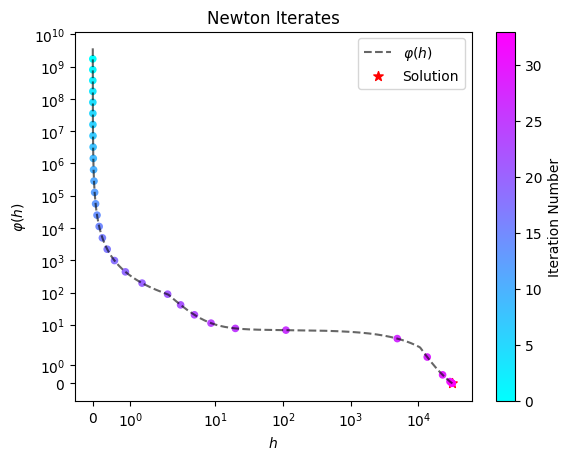

In [499]:
np.random.seed(0)
p = 100
L, v = gl.data.generate_block_norm_data(p, 0.2, 0.1)
l1 = 1e-4
l2 = 0
fig = assess_newton(L, v, l1, l2)
fig.savefig('figures/newton_stuck_alone.pdf', bbox_inches='tight')

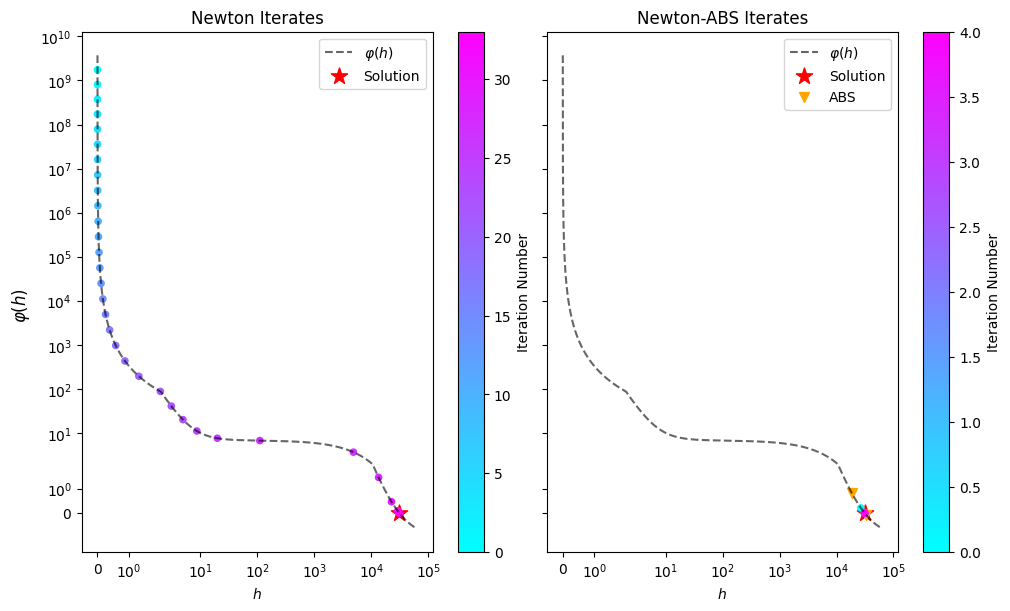

In [500]:
np.random.seed(0)
p = 100
L, v = gl.data.generate_block_norm_data(p, 0.2, 0.1)
l1 = 1e-4
l2 = 0
data_out = assess(L, v, l1, l2)
data_out['plot'][0].savefig('figures/newton_stuck.pdf', bbox_inches='tight')